# Imports

In [1]:
import os
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt


# Variables

In [2]:
BATCH_SIZE = 32
EPOCHS = 10
IMG_SIZE = (160, 160)
SEED = 42

train_dir = pathlib.Path("/Users/leonardo/Documents/Projects/cryptovision/data/processed/train")
test_dir = pathlib.Path("/Users/leonardo/Documents/Projects/cryptovision/data/processed/test")
val_dir = pathlib.Path("/Users/leonardo/Documents/Projects/cryptovision/data/processed/valid")

# Setup Dataset

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
)

Found 5789 files belonging to 57 classes.
Found 1448 files belonging to 57 classes.
Found 1810 files belonging to 57 classes.


2024-10-25 13:20:52.621171: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-10-25 13:20:52.621195: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-10-25 13:20:52.621201: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-10-25 13:20:52.621213: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-25 13:20:52.621223: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# View Some Images

In [4]:
class_names = train_ds.class_names

plt.figure(figsize=(15, 10))
#for images, labels in train_ds.take(1):
#  for i in range(9):
#    ax = plt.subplot(3, 3, i + 1)
#    plt.imshow(images[i].numpy().astype("uint8"))
#    plt.title(class_names[labels[i]])
#    plt.axis("off")

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

# AutoTune Dataset

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Data Augmentation

In [6]:
# Data Augmentation Function
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomTranslation(0.1, 0.1),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomBrightness(0.2),
        #tf.keras.layers.GaussianNoise(0.2),
    ]
)

## View Augmented Images

2024-10-25 13:20:53.511716: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


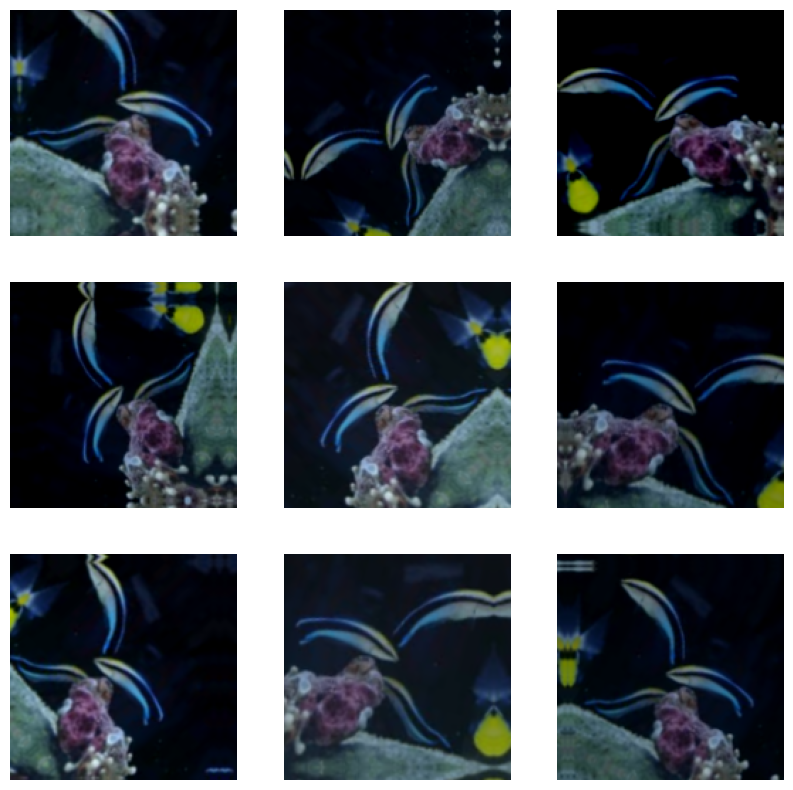

In [7]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [8]:
# MobileNetV2 Image Preprocessing
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

# Create Base Model
base_model = tf.keras.applications.ResNet50V2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

In [9]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


In [10]:
from tensorflow.keras.layers import Layer

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.dense = tf.keras.layers.Dense(input_shape[-1], activation='sigmoid')
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # Global Average Pooling
        avg_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)
        # Dense layer to learn attention weights
        attention = self.dense(avg_pool)
        # Reshape attention weights to match the input dimensions
        attention = tf.keras.layers.Reshape((1, 1, inputs.shape[-1]))(attention)
        # Multiply the attention weights with the original inputs
        output = tf.keras.layers.Multiply()([inputs, attention])
        return output


In [13]:
def create_model(attention=False):
    inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
    x = data_augmentation(inputs) 
    x = preprocess_input(x) 
    x = base_model(x, training=False)

    if attention:
        x = AttentionLayer()(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(57, activation='softmax', name='output')(x)
    model = tf.keras.Model(inputs, outputs)
    
    base_learning_rate = 0.0001
    model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
    loss="categorical_crossentropy", 
    metrics=['accuracy'],
    )

    return model

In [14]:
model_att = create_model(attention=True)
model = create_model(attention=False)

In [15]:
loss0, accuracy0 = model.evaluate(test_ds)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

2024-10-25 13:24:18.459340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.0122 - loss: 5.7991
initial loss: 5.79
initial accuracy: 0.01


In [16]:
loss0, accuracy0 = model_att.evaluate(test_ds)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.0237 - loss: 4.5049
initial loss: 4.49
initial accuracy: 0.02


In [17]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)

Epoch 1/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 28s 130ms/step - accuracy: 0.0474 - loss: 4.8980 - val_accuracy: 0.2659 - val_loss: 3.0752
Epoch 2/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.2324 - loss: 3.1087 - val_accuracy: 0.4351 - val_loss: 2.2217
Epoch 3/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - accuracy: 0.3880 - loss: 2.3744 - val_accuracy: 0.5249 - val_loss: 1.8175
Epoch 4/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - accuracy: 0.4413 - loss: 2.0609 - val_accuracy: 0.5843 - val_loss: 1.5870
Epoch 5/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - accuracy: 0.5133 - loss: 1.7932 - val_accuracy: 0.6209 - val_loss: 1.4439
Epoch 6/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - accuracy: 0.5501 - loss: 1.6466 - val_accuracy: 0.6485 - val_loss: 1.3406
Epoch 7/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - accuracy: 0.5886 - loss: 1.5337 - val_accuracy: 0.6720 - val_loss: 1.2643
Epoch 8/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 23s 126ms/step - accuracy: 0.6077 - loss: 1

In [19]:
loss0, accuracy0 = model.evaluate(test_ds)

print("Post Training loss: {:.2f}".format(loss0))
print("Post Training accuracy: {:.2f}".format(accuracy0))

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.6840 - loss: 1.1467
Post Training loss: 1.09
Post Training accuracy: 0.71


In [22]:
history_att = model_att.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)

Epoch 1/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - accuracy: 0.1540 - loss: 3.6296 - val_accuracy: 0.5041 - val_loss: 2.1767
Epoch 2/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 24s 130ms/step - accuracy: 0.4809 - loss: 2.2066 - val_accuracy: 0.6070 - val_loss: 1.6568
Epoch 3/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 24s 131ms/step - accuracy: 0.5876 - loss: 1.7352 - val_accuracy: 0.6623 - val_loss: 1.4007
Epoch 4/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 24s 130ms/step - accuracy: 0.6216 - loss: 1.5322 - val_accuracy: 0.6920 - val_loss: 1.2547
Epoch 5/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 24s 133ms/step - accuracy: 0.6584 - loss: 1.3352 - val_accuracy: 0.7127 - val_loss: 1.1549
Epoch 6/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 24s 133ms/step - accuracy: 0.6932 - loss: 1.2244 - val_accuracy: 0.7272 - val_loss: 1.0850
Epoch 7/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 24s 131ms/step - accuracy: 0.7053 - loss: 1.1298 - val_accuracy: 0.7320 - val_loss: 1.0294
Epoch 8/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 23s 129ms/step - accuracy: 0.7307 - loss: 1

In [24]:
loss0, accuracy0 = model_att.evaluate(test_ds)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.7535 - loss: 0.9215
initial loss: 0.91
initial accuracy: 0.75


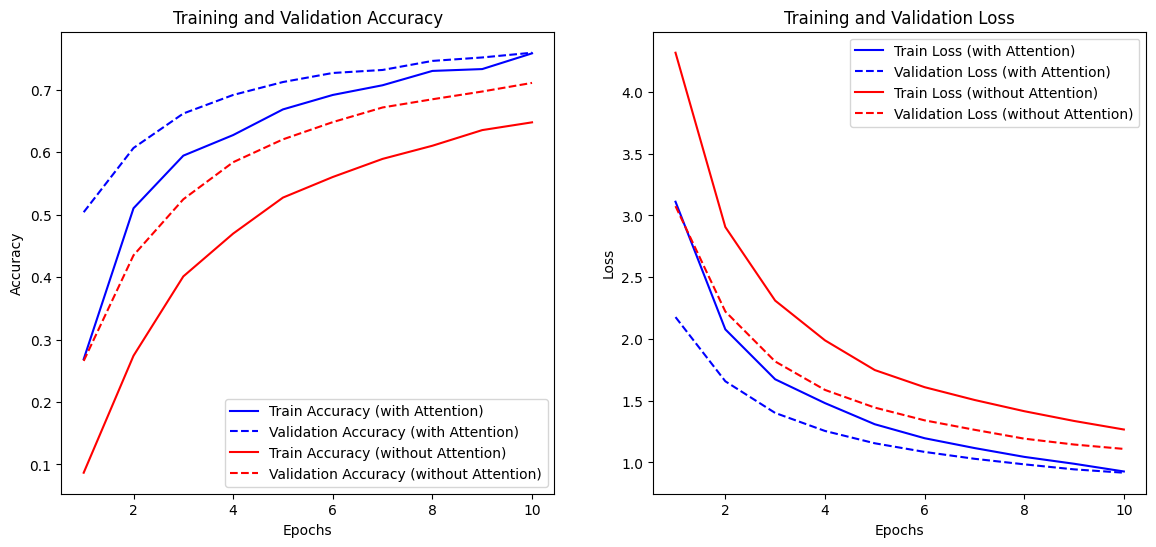

In [25]:
import matplotlib.pyplot as plt

def plot_history(history_with_attention, history_without_attention):
    # Extract the relevant data from the histories
    acc_with_attention = history_with_attention.history['accuracy']
    val_acc_with_attention = history_with_attention.history['val_accuracy']
    loss_with_attention = history_with_attention.history['loss']
    val_loss_with_attention = history_with_attention.history['val_loss']
    
    acc_without_attention = history_without_attention.history['accuracy']
    val_acc_without_attention = history_without_attention.history['val_accuracy']
    loss_without_attention = history_without_attention.history['loss']
    val_loss_without_attention = history_without_attention.history['val_loss']
    
    epochs = range(1, len(acc_with_attention) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc_with_attention, 'b', label='Train Accuracy (with Attention)')
    plt.plot(epochs, val_acc_with_attention, 'b--', label='Validation Accuracy (with Attention)')
    plt.plot(epochs, acc_without_attention, 'r', label='Train Accuracy (without Attention)')
    plt.plot(epochs, val_acc_without_attention, 'r--', label='Validation Accuracy (without Attention)')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss_with_attention, 'b', label='Train Loss (with Attention)')
    plt.plot(epochs, val_loss_with_attention, 'b--', label='Validation Loss (with Attention)')
    plt.plot(epochs, loss_without_attention, 'r', label='Train Loss (without Attention)')
    plt.plot(epochs, val_loss_without_attention, 'r--', label='Validation Loss (without Attention)')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history_att, history)

In [26]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_2 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_2 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 5, 5, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 57)             │       116,793 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,915,181 (91.23 MB)

 Trainable params: 116,793 (456.22 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

 Optimizer params: 233,588 (912.46 KB)

In [27]:
model_att.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 5, 5, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_1               │ (None, 5, 5, 2048)     │     4,196,352 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 57)             │       116,793 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,504,237 (139.25 MB)

 Trainable params: 4,313,145 (16.45 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

 Optimizer params: 8,626,292 (32.91 MB)